[[-40.96  10.24   0.   ...   0.     0.     0.  ]
 [ 10.24 -40.96  10.24 ...   0.     0.     0.  ]
 [  0.    10.24 -40.96 ...   0.     0.     0.  ]
 ...
 [  0.     0.     0.   ... -40.96  10.24   0.  ]
 [  0.     0.     0.   ...  10.24 -40.96  10.24]
 [  0.     0.     0.   ...   0.    10.24 -40.96]]
(4096, 4096)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.  1.6 0.  ... 0.  0.  0. ]
[-1.6  0.   1.6 ...  0.   0.   0. ]
[[ 0.   1.6  0.  ...  0.   0.   0. ]
 [-1.6  0.   1.6 ...  0.   0.   0. ]
 [ 0.  -1.6  0.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.   1.6  0. ]
 [ 0.   0.   0.  ... -1.6  0.   1.6]
 [ 0.   0.   0.  ...  0.  -1.6  0. ]]
(4096,)
[[2.50656748e-46 1.17762859e-43 4.55107657e-41 ... 1.96785570e-38
  6.19028421e-41 1.60178709e-43]
 [3.54964961e-45 6.53319004e-43 1.92934361e-40 ... 1.23357409e-37
  5.33777602e-40 1.99380943e-42]
 [1.85768096e-44 2.62245678e-42

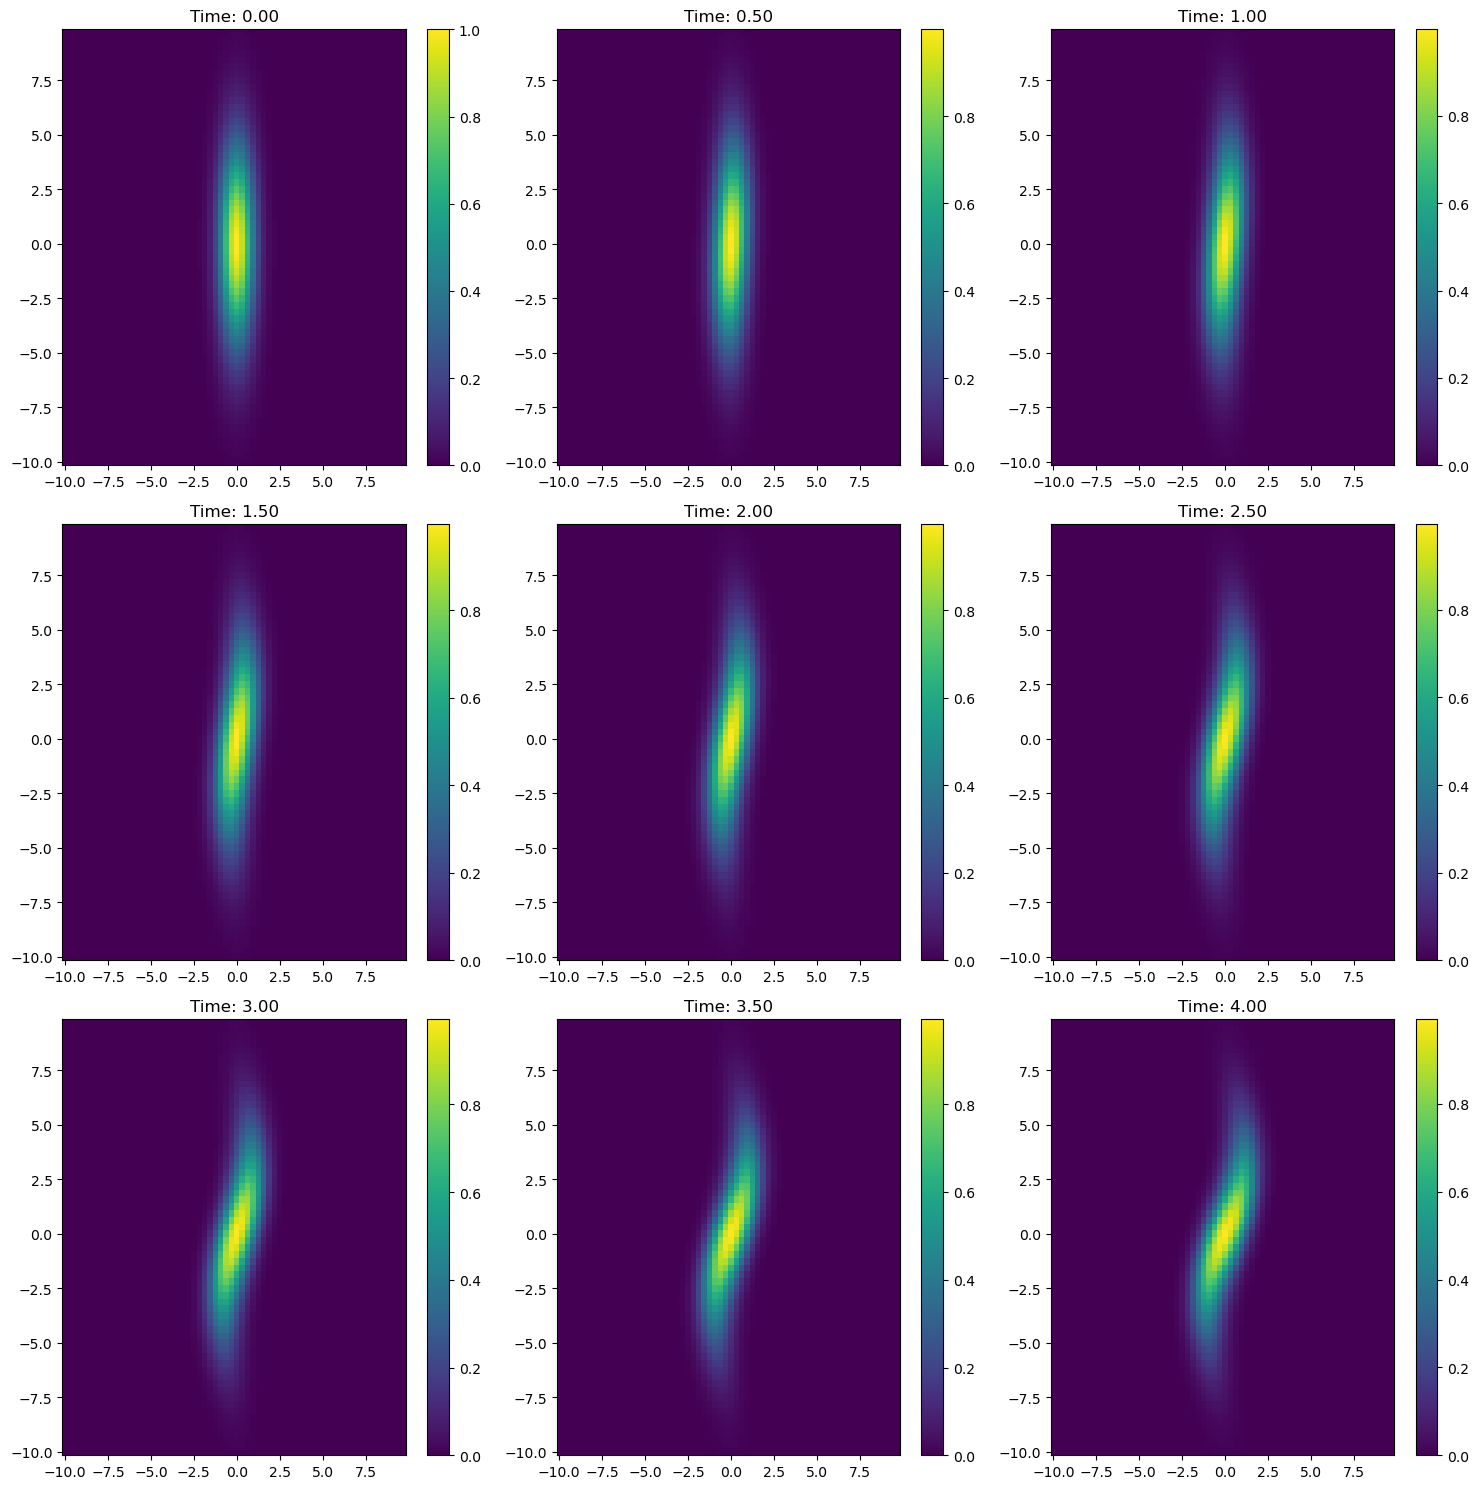

In [6]:
import numpy as np
from scipy.sparse import spdiags
import matplotlib.pyplot as plt

# Define parameters
m = 64
n = m * m 
x_min, x_max = -10, 10
dx = (x_max - x_min) / m

# total size of matrix
e0 = np.zeros(n) 
e1 = np.ones(n) 
e2 = np.copy(e1) 
e4 = np.copy(e0) 

for j in range(1, m+1):
    e2[m*j-1] = 0 
    e4[m*j-1] = 1 

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]
e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

# Place diagonal elements
diagonals = [e1.flatten(), e1.flatten(), e5.flatten(),e2.flatten(),-4*e1.flatten(), e3.flatten(),e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]
A = spdiags(diagonals, offsets, n, n).toarray()
A = A/(dx**2)
print(A)
print(A.shape)

# Create matrix B
e = np.ones(n)

data_B = [e, -1*e, e, -1*e]
offsets_B = [-(n-m), -m, m, (n - m)]
B = spdiags(data_B, offsets_B, n, n).toarray()
B = B/(2*dx)
print(B)

# Create matrix C
e1 = np.zeros(n)
e2 = np.ones(n)
e3 = np.ones(n)
e4 = np.zeros(n)


for i in range(n):
    if (i + 1) % m == 1:
        e1[i] = 1
        e3[i] = 0
    if (i + 1) % m == 0:
        e2[i] = 0
        e4[i] = 1

e2 = -1*e2
e4 = -1*e4

C = spdiags([e1,e2, e3,e4],[-m+1, -1,1,m-1], n,n).toarray()
C = C/(2*dx)
            
print(C[0,:])
print(C[1,:])
print(C)


import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp

# Define parameters
tspan = np.arange(0, 4 + 0.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1*np.exp(-(X**2) - (Y**2)/20)

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

def spc_rhs(t, wt2, nx, ny, N, KX, KY, K, nu, A, B, C):
    
    wt = wt2.reshape((nx, ny))
    wtfft = fft2(wt)
    psix = np.real(ifft2(-wtfft / K)).flatten()
    rhs = (nu * (A @ wt2) + (B @ wt2) * (C @ psix) - (B @ psix) * (C @ wt2))
    
    return rhs

# Solve the ODE
w = w.flatten()
print(w.shape)


sol = solve_ivp(spc_rhs,t_span=[0, 4],y0=w,t_eval=tspan,method='RK45',args=(nx, ny, N, KX, KY, K, nu ,A,B,C))
A1 = sol.y.T
print(A1)
print(A1.shape)

# Solve ODE
#sol = solve_ivp(spc_rhs,t_span=[0, 4],y0=w,t_eval=tspan,method='RK45')

# Reshape solution
solution_real = sol.y.T.reshape(-1, nx, ny)

# Plot results
n_plots = len(tspan)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5*n_rows))

for j, t in enumerate(tspan):
    plt.subplot(n_rows, n_cols, j + 1)
    plt.pcolormesh(X, Y, solution_real[j], shading='auto', cmap='viridis')
    plt.title(f'Time: {t:.2f}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [10]:
from scipy.linalg import solve_triangular, lu
import numpy as np

# matrix A
A[0,0] = 2/(dx**2)

# Define Direct solver function
def Direct(t, w, A, B, C, nu):

    psi = np.linalg.solve(A, w)
    psix = B @ psi
    psiy = C @ psi
    wx = B @ w
    wy = C @ w
    rhs = nu * (A @ w) - psix * wy + psiy * wx
    return rhs

# Define LU solver function
def LU_solver(t, w, A, B, C, nu, P, L, U):

    y = solve_triangular(L, P @ w, lower=True)
    psi = solve_triangular(U, y)
    psix = B @ psi
    psiy = C @ psi
    wx = B @ w
    wy = C @ w
    rhs = nu * (A @ w) - psix * wy + psiy * wx
    return rhs

# Time parameters
t_start = 0.0
t_end = 4.0
dt = 0.5
tspan = np.arange(t_start, t_end + dt, dt)

# Perform LU decomposition
P, L, U = lu(A)

# Make sure w is flattened
w = w.flatten()
print("Initial condition shape:", w.shape)

# Solve the ODE using both methods
direct_sol = solve_ivp(Direct,t_span=[t_start, t_end],y0=w,t_eval=tspan,method='RK45',args=(A, B, C, nu))

lu_sol = solve_ivp(LU_solver,t_span=[t_start, t_end],y0=w,t_eval=tspan,method='RK45',args=(A, B, C, nu, P, L, U))

# Extract and reshape solutions
A2 = direct_sol.y.T
A3 = lu_sol.y.T

print("A2:",A2)
print("A3:",A3)


print("Direct solution shape:", A2.shape)
print("LU solution shape:", A3.shape)

# Optional: Compare solutions
max_difference = np.max(np.abs(A2 - A3))
print("Maximum difference between solutions:", max_difference)

Initial condition shape: (4096,)
A2: [[ 2.50656748e-46  1.17762859e-43  4.55107657e-41 ...  1.96785570e-38
   6.19028421e-41  1.60178709e-43]
 [-1.78630705e-36 -2.26093387e-29 -4.24661881e-29 ...  7.20814729e-28
   1.69117621e-28  5.05834665e-29]
 [ 1.02614869e-36  1.85614646e-29  3.48720993e-29 ... -6.58759786e-28
  -1.49205998e-28 -4.38046443e-29]
 ...
 [-5.75086257e-26 -1.48306461e-19 -2.20165937e-20 ...  4.01674620e-20
   3.00460834e-20  2.47633369e-20]
 [-6.68013806e-25 -7.82424220e-19 -2.91637720e-19 ...  1.34371413e-19
   1.76009486e-19  1.15181522e-20]
 [ 3.02201851e-24  1.67449651e-18  1.23961335e-18 ... -8.94163775e-19
  -9.80736832e-19  3.12761254e-20]]
A3: [[ 2.50656748e-46  1.17762859e-43  4.55107657e-41 ...  1.96785570e-38
   6.19028421e-41  1.60178709e-43]
 [-1.78630705e-36 -2.26093387e-29 -4.24661881e-29 ...  7.20814729e-28
   1.69117621e-28  5.05834665e-29]
 [ 1.02614869e-36  1.85614646e-29  3.48720993e-29 ... -6.58759786e-28
  -1.49205998e-28 -4.38046443e-29]
 ...
 [-

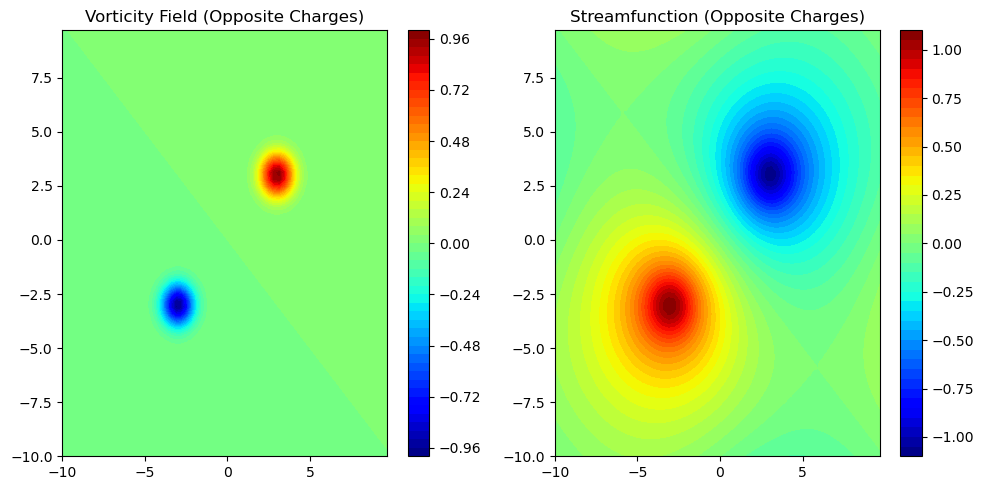

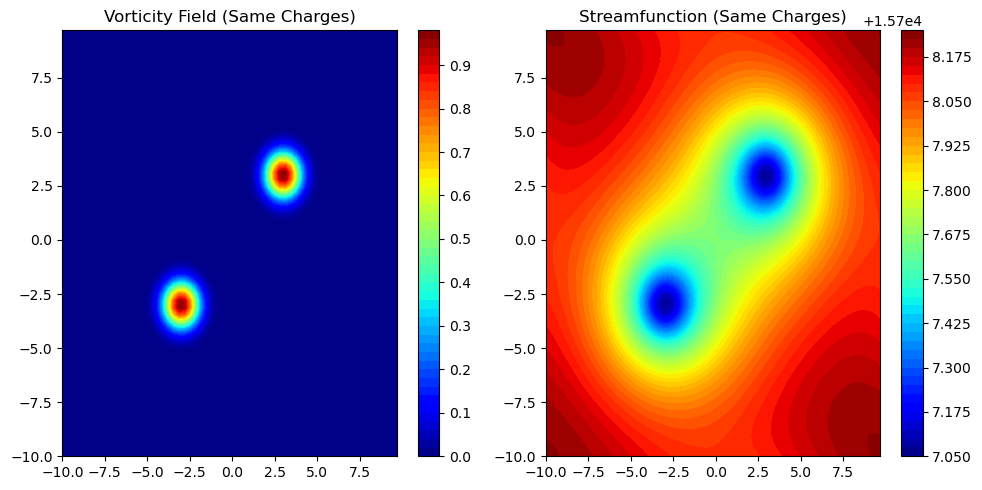

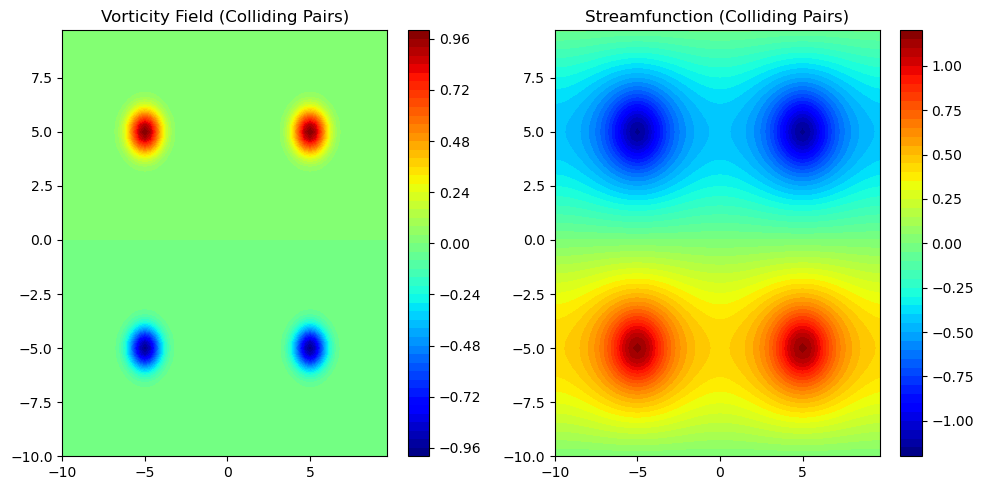

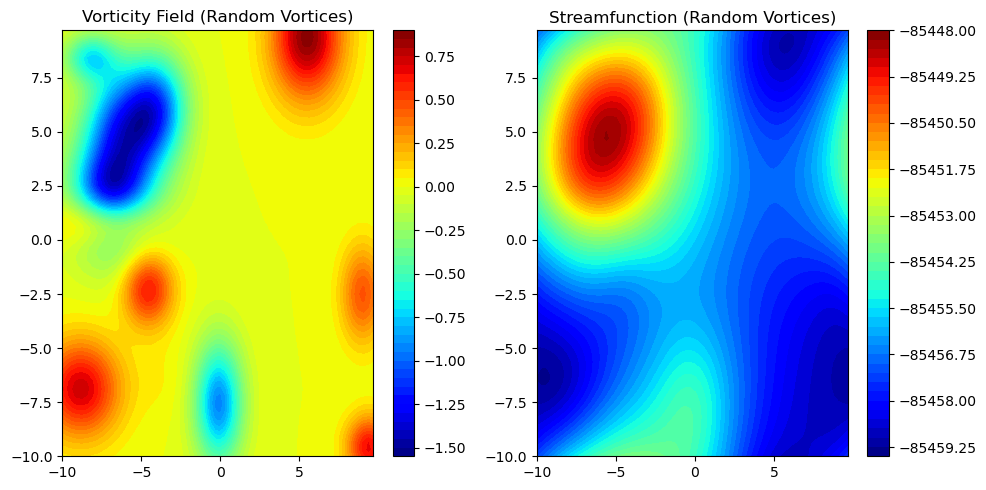

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import eye
from scipy.sparse.linalg import spsolve

# Parameters
L = 10
n = 64  # Adjust to 32 for faster execution if needed
x = np.linspace(-L, L, n, endpoint=False)
y = np.linspace(-L, L, n, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')

# Function to create vorticity fields
def generate_vorticity_field(case):
    omega = np.zeros((n, n))
    if case == "opposite_charges":
        omega += np.exp(-((X - 3)**2 + (Y - 3)**2))  # Positive vortex
        omega -= np.exp(-((X + 3)**2 + (Y + 3)**2))  # Negative vortex
    elif case == "same_charges":
        omega += np.exp(-((X - 3)**2 + (Y - 3)**2))
        omega += np.exp(-((X + 3)**2 + (Y + 3)**2))
    elif case == "colliding_pairs":
        omega += np.exp(-((X - 5)**2 + (Y - 5)**2))  # Pair 1, positive
        omega -= np.exp(-((X + 5)**2 + (Y + 5)**2))  # Pair 1, negative
        omega += np.exp(-((X - 5)**2 + (Y + 5)**2))  # Pair 2, positive
        omega -= np.exp(-((X + 5)**2 + (Y - 5)**2))  # Pair 2, negative
    elif case == "random_vortices":
        np.random.seed(42)
        for _ in range(15):
            x0, y0 = np.random.uniform(-L, L, size=2)
            strength = np.random.uniform(-1, 1)
            sigma_x = np.random.uniform(1, 3)
            sigma_y = np.random.uniform(1, 3)
            omega += strength * np.exp(-((X - x0)**2 / sigma_x**2 + (Y - y0)**2 / sigma_y**2))
    return omega

# Precompute Laplacian matrix
def construct_laplacian(n, dx):
    from scipy.sparse import spdiags, kron, eye, csc_matrix

    e = np.ones(n)
    D2 = spdiags([e, -2 * e, e], [-1, 0, 1], n, n) / dx**2
    D2 = D2.tolil()
    D2[0, -1] = 1 / dx**2  # Periodic BC
    D2[-1, 0] = 1 / dx**2
    D2 = D2.tocsr()
    I_n = eye(n, format='csr')
    A = kron(D2, I_n) + kron(I_n, D2)
    return csc_matrix(A)

dx = 2 * L / n
epsilon = 1e-6
A = construct_laplacian(n, dx) + epsilon * eye(n**2, format='csc')  # Precomputed Laplacian

# Function to solve Poisson equation
def solve_poisson(A, b):
    return spsolve(A, b)

# Solve and visualize for each case
cases = ["opposite_charges", "same_charges", "colliding_pairs", "random_vortices"]

for case in cases:
    omega = generate_vorticity_field(case)
    omega_vec = omega.flatten()

    try:
        psi_vec = solve_poisson(A, omega_vec)
        psi = psi_vec.reshape((n, n))
    except ValueError as e:
        print(f"Failed to solve for case {case}: {e}")
        continue

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.contourf(x, y, omega, levels=50, cmap='jet')
    plt.colorbar()
    plt.title(f"Vorticity Field ({case.replace('_', ' ').title()})")

    plt.subplot(1, 2, 2)
    plt.contourf(x, y, psi, levels=50, cmap='jet')
    plt.colorbar()
    plt.title(f"Streamfunction ({case.replace('_', ' ').title()})")

    plt.tight_layout()
    plt.show()